In [1]:
from pathlib import Path
import pandas as pd

In [2]:
PATH = Path("/kaggle/input/google-research-identify-contrails-reduce-global-warming")
contenido = [elemento.name for elemento in PATH.iterdir()]

for elemento in contenido:
    print(elemento)

validation_metadata.json
train_metadata.json
sample_submission.csv
validation
test
train


In [3]:
# Leemos json
train_metadata = pd.read_json(PATH/'train_metadata.json')
train_metadata

,record_id,projection_wkt,row_min,row_size,col_min,col_size,timestamp
0,3283699311323360256,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",1686563.500,-1960.975830,371650.93750,1947.130737,2019-10-13 23:20:00
1,8563667897034605568,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",3182392.750,-1977.611084,360291.81250,1938.791138,2019-08-21 08:40:00
2,6375533009500587008,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",2702499.500,-2035.440063,830456.93750,1890.603882,2019-10-04 20:40:00
3,3029407526724838912,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",2689881.500,-1998.106812,565498.75000,1918.643677,2019-10-07 00:00:00
4,4486503791474809856,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4179394.250,-2073.804688,736862.00000,1853.664795,2019-10-29 16:30:00
...,...,...,...,...,...,...,...
20524,2784921205987946496,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",1191489.125,-1967.661011,584308.25000,1942.752441,2019-10-17 17:20:00
20525,9072953982653736960,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",3694398.500,-2033.623047,622599.50000,1889.533081,2019-10-16 00:40:00
20526,2998013562139868160,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",1187086.250,-1948.682129,225060.00000,1956.457520,2019-10-10 19:20:00
20527,8070893861055857664,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4195883.000,-2047.418579,614459.68750,1877.985962,2019-12-06 12:40:00


In [4]:
# Cada record_id está asociado a una carpeta de imagenes en train
files = Path("/kaggle/input/google-research-identify-contrails-reduce-global-warming/train")
records = [elemento.name for elemento in files.iterdir()]
len(records) # Hay la misma cantidad de carpetas que records_id
# Busquemos que trae adentro ese record_id
images = Path(f"/kaggle/input/google-research-identify-contrails-reduce-global-warming/train/{records[0]}")
contenido = [elemento.name for elemento in images.iterdir()]
contenido # Cada record posee las bandas asociadas a los instantes de cada imagen satelital

['band_10.npy',
 'band_14.npy',
 'human_individual_masks.npy',
 'band_15.npy',
 'band_16.npy',
 'band_08.npy',
 'band_09.npy',
 'band_13.npy',
 'band_11.npy',
 'human_pixel_masks.npy',
 'band_12.npy']

In [5]:
# Abramos una imagen satelital
import numpy as np
image = np.load(images/'band_15.npy')
image.shape # Tiene 8 instantes temporales

(256, 256, 8)

In [6]:
# Abramos la mascara
mask = np.load(images/'human_pixel_masks.npy')

In [7]:
mask.shape
pixels = [pixel for pixel in mask.flatten()] # Voy a estirarla para ver si detecta algo
if not 1 in pixels:
    print('No') # No hay 1, por lo que la mascara no posee estelas

No


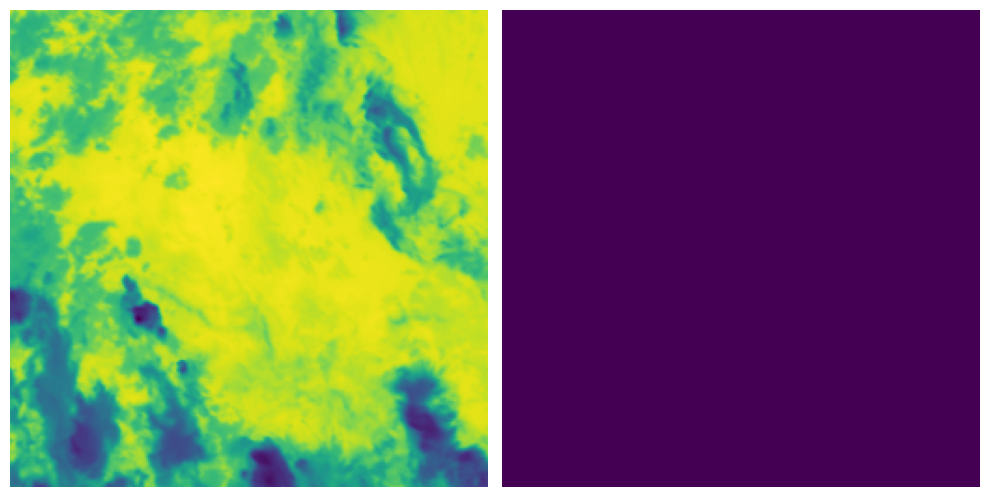

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 2, 1)
ax.imshow(image[...,4]) # Instante 5, corresponde a la mascara
ax.axis('off')

ax = plt.subplot(1, 2, 2)
ax.imshow(mask[...,0])
ax.axis('off')
plt.tight_layout()
plt.show()

In [9]:
from tqdm import tqdm

In [10]:
bands = range(8,17)
stats = {b: {'min': [], 'max': [], 'mean': [], 'std': []} for b in bands}
for record in tqdm(records):
    for band in bands:
        image = np.load(PATH / 'train' / record / f'band_{band:02d}.npy') # Antecede 0 si es un número único
        stats[band]['min'].append(image.min())
        stats[band]['max'].append(image.max())
        stats[band]['mean'].append(image.mean())
        stats[band]['std'].append(image.std())

100%|██████████| 20529/20529 [1:11:58<00:00,  4.75it/s]


In [11]:
final_stats = {
    b: {
        'min': np.min(stats[b]['min']),
        'max': np.max(stats[b]['max']),
        'mean': np.mean(stats[b]['mean']),
        'std': np.mean(stats[b]['std'])
    }
    for b in bands
}

In [12]:
final_stats = {8: {'min': 175.82391, 'max': 280.14868, 'mean': 233.6769, 'std': 4.5457406},
 9: {'min': 180.74695, 'max': 279.4869, 'mean': 242.25444, 'std': 6.0571766},
 10: {'min': 181.44263, 'max': 331.13394, 'mean': 250.75069, 'std': 7.620164},
 11: {'min': 179.33739, 'max': 332.06036, 'mean': 274.41205, 'std': 13.668153},
 12: {'min': 187.69131, 'max': 306.21823, 'mean': 255.52716, 'std': 8.708824},
 13: {'min': 179.3451, 'max': 338.0567, 'mean': 276.6018, 'std': 14.446373},
 14: {'min': 178.71164, 'max': 338.6333, 'mean': 275.3594, 'std': 14.736153},
 15: {'min': 178.36511, 'max': 333.21048, 'mean': 272.56412, 'std': 14.367305},
 16: {'min': 137.39153, 'max': 311.97977, 'mean': 260.4258, 'std': 11.049051}}

In [13]:
final_stats # Lo ocuparemos más adelante para normalizar las imagenes

{8: {'min': 175.82391, 'max': 280.14868, 'mean': 233.6769, 'std': 4.5457406},
 9: {'min': 180.74695, 'max': 279.4869, 'mean': 242.25444, 'std': 6.0571766},
 10: {'min': 181.44263, 'max': 331.13394, 'mean': 250.75069, 'std': 7.620164},
 11: {'min': 179.33739, 'max': 332.06036, 'mean': 274.41205, 'std': 13.668153},
 12: {'min': 187.69131, 'max': 306.21823, 'mean': 255.52716, 'std': 8.708824},
 13: {'min': 179.3451, 'max': 338.0567, 'mean': 276.6018, 'std': 14.446373},
 14: {'min': 178.71164, 'max': 338.6333, 'mean': 275.3594, 'std': 14.736153},
 15: {'min': 178.36511, 'max': 333.21048, 'mean': 272.56412, 'std': 14.367305},
 16: {'min': 137.39153, 'max': 311.97977, 'mean': 260.4258, 'std': 11.049051}}

In [14]:
df = pd.DataFrame(final_stats)
df = df.T
df.to_csv('/kaggle/working/stats.csv')

In [15]:
stats = pd.read_csv('/kaggle/working/stats.csv', index_col=0)

In [16]:
stats

,min,max,mean,std
8,175.82391,280.14868,233.67690,4.545741
9,180.74695,279.48690,242.25444,6.057177
10,181.44263,331.13394,250.75069,7.620164
11,179.33739,332.06036,274.41205,13.668153
12,187.69131,306.21823,255.52716,8.708824
13,179.34510,338.05670,276.60180,14.446373
14,178.71164,338.63330,275.35940,14.736153
15,178.36511,333.21048,272.56412,14.367305
16,137.39153,311.97977,260.42580,11.049051


In [17]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, masks=None, trans=None, stats = stats):
        self.images = images
        self.masks = masks
        self.trans = trans
        self.stats = stats
    def __len__(self):
        return len(self.images)
    def __getitem__(self, ix):
        bands = range(8,17)
        data = []
        # Iteramos en todas las bandas dentro del directorio asociado al record_id
        for band in bands:
            image = np.load(f'{self.images[ix]}/band_{band:02d}.npy') # El formato :02d permite anteceder un 0 cuando hay número único
            image = (image - self.stats.loc[band]['mean'])/ self.stats.loc[band]['std'] # Normalizamos
            data.append(image)
        data = np.stack(data, axis=-1) # Apilamos las matrices en la última dimensión, es decir, las bandas
        image = data[..., 4, :] # Recuperamos el instante 4 de todas las bandas, ya que con ese instante se hizo la mascara
        if self.masks is not None:
            mask = np.load(self.masks[ix]) # Cargamos mascara
            if self.trans is not None: # Data augmentation
                trans = self.trans(image = image, mask = mask)
                image, mask = trans['image'], trans['mask']
            return torch.from_numpy(image).permute(2,0,1), torch.from_numpy(mask).permute(2,0,1)
        #Permute para tener los canales primero
        image = self.trans(image=image)['image']
        return torch.from_numpy(image).permute(2,0,1)

In [18]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.0 MB/s eta 0:00:00


In [19]:
import lightning as L
from torch.utils.data import DataLoader

class DataModule(L.LightningDataModule):
    def __init__(self, 
                 path = '/kaggle/input/google-research-identify-contrails-reduce-global-warming',
                 batch_size = 64,
                 train_trans = None,
                 val_trans = None
                ):
        super().__init__()
        self.path = path
        self.batch_size = batch_size
        self.train_trans = train_trans # Data augmentation
        self.val_trans = val_trans
    
    def setup(self, stage=None):
        files_train = Path(f'{self.path}/train')
        train_records = [elemento.name for elemento in files_train.iterdir()] # Leemos todos los records
        train_images = [files_train / record for record in train_records] # Lista con la path de los record
        train_masks = [files_train / record / 'human_pixel_masks.npy' for record in train_records] # Lista con la path de cada mascara dentro del record
        self.train_ds = Dataset(train_images, train_masks, self.train_trans)
        # train_images[ix] =  /kaggle/input/google-research-identify-contrails-rduce-global-warming/3283699311323360256
        # train_masks[ix] = /kaggle/input/google-research-identify-contrails-rduce-global-warming/3283699311323360256/human_pixel_masks.npy
        
        files_val = Path(f'{self.path}/validation')
        val_records = [elemento.name for elemento in files_val.iterdir()]
        val_images = [files_val / record for record in val_records]
        val_masks = [files_val / record / 'human_pixel_masks.npy' for record in val_records]
        self.val_ds = Dataset(val_images, val_masks, self.val_trans)
    
    def train_dataloader(self, shuffle=True):
        return DataLoader(
            self.train_ds, 
            batch_size = self.batch_size, 
            shuffle = shuffle, 
            num_workers=2, 
            pin_memory=True
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_ds, 
            batch_size = self.batch_size, 
            num_workers=2, 
            pin_memory=True
        )

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [20]:
dm = DataModule()
dm.setup()

In [21]:
images, masks = next(iter(dm.train_dataloader()))

In [22]:
images.shape, masks.shape, images.dtype, masks.dtype
# Batch 8 imagenes de 256x256 y 9 bandas

(torch.Size([64, 9, 256, 256]),
 torch.Size([64, 1, 256, 256]),
 torch.float32,
 torch.int32)

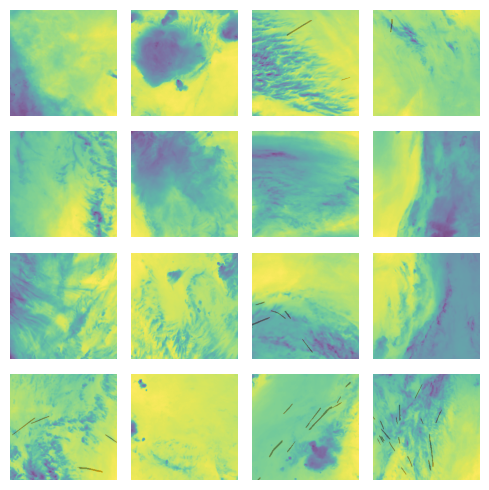

In [23]:
fig = plt.figure(figsize=(5, 5))
rows, cols = 4,4
for i in range(rows*cols):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(images[i][0]) # Primera banda
    plt.imshow(masks[i][0], alpha = 0.3, cmap='Reds') # Sobreponemos mascarac
    plt.axis('off')
plt.tight_layout()
plt.show()

In [24]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - \ done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=55339b5cb423e018bc7e49eaa7020bcc83d66aac1a54964082d518cedeefe3cb
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=c27e16b0deb88c9aceb2d00e51c5047416528334d8a5eccc201d90014c130c73
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [25]:
import segmentation_models_pytorch as smp
import torchmetrics

class Unet(L.LightningModule):
    def __init__(self, hparams = {}):
        super().__init__()
        if not 'encoder' in hparams:
            hparams['encoder'] = 'resnet18'
        if not 'optimizer' in hparams:
            hparams['optimizer'] = 'Adam'
        if not 'optimizer_params' in hparams:
            hparams['optimizer_params'] = {}
        self.save_hyperparameters(hparams)
        self.model = smp.Unet(
            encoder_name = self.hparams.encoder,
            encoder_weights = "imagenet",
            in_channels = 9,
            classes = 1
        ) 
        self.loss = smp.losses.DiceLoss(mode="binary")
        self.metric = torchmetrics.Dice()
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        metric = self.metric(y_hat, y)
        self.log('loss', loss, prog_bar = True)
        self.log('metric', metric, prog_bar = True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        metric = self.metric(y_hat, y)
        self.log('val_loss', loss, prog_bar = True)
        self.log('val_metric', metric, prog_bar = True)
        
    def configure_optimizers(self):
        optimizer = getattr(torch.optim, self.hparams.optimizer)(
            self.parameters(), **self.hparams['optimizer_params'])
        if 'scheduler' in self.hparams:
            shedulers = [
                getattr(torch.optim.lr_scheduler, scheduler)(
                optimizer, **params)
                for scheduler, params in self.hparams.scheduler.items()
            ]
            return [optimizer], scheduler
        return optimizer

In [26]:
hparams = {
    'encoder': 'resnet18',
    'optimizer': 'Adam',
    'optimizer_params': {
        'lr': 1e-3
    }
}

In [27]:
unet = Unet()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


In [28]:
# Carpeta para test
import os

os.makedirs('/kaggle/working/checkpoints')

In [29]:
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor

checkpoint_callback_val = ModelCheckpoint(
                dirpath='./checkpoints',
                filename=f'experiment-1-{{val_metric:.5f}}-{{epoch}}',
                monitor='val_metric',
                mode='max',
                save_top_k=1
            ) # Elige la mejor val_metric "Dice"

checkpoint_callback_epoch = ModelCheckpoint(
                dirpath='./checkpoints',
                filename=f'experiment-1-{{epoch}}',
                monitor='epoch',
                mode='max',
                save_top_k=1    
            )

callbacks = [checkpoint_callback_val, checkpoint_callback_epoch]

In [30]:
# LOGGER
from lightning.pytorch.loggers import WandbLogger

wb = WandbLogger(
                proyect="Contrails",
                name="experiment-1",
            )

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 # LOGGER                                                                                     │
│   2 from lightning.pytorch.loggers import WandbLogger                                            │
│   3                                                                                              │
│ ❱ 4 wb = WandbLogger(                                                                            │
│   5 │   │   │   │   proyect="Contrails",                                                         │
│   6 │   │   │   │   name="experiment-1",                                                         │
│   7 │   │   │   )                                                                                │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:358 in __init__       │
│                                                                                                  │
│   355 │   │   # start wandb run (to create an attach_id for distributed modes)                   │
│   356 │   │   if _WANDB_GREATER_EQUAL_0_12_10:                                                   │
│   357 │   │   │   wandb.require("service")                                                       │
│ ❱ 358 │   │   │   _ = self.experiment                                                            │
│   359 │   │                                                                                      │
│   360 │   │   self._checkpoint_name = checkpoint_name                                            │
│   361                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/lightning/fabric/loggers/logger.py:114 in experiment     │
│                                                                                                  │
│   111 │   │   """                                                                                │
│   112 │   │   if rank_zero_only.rank > 0:                                                        │
│   113 │   │   │   return _DummyExperiment()                                                      │
│ ❱ 114 │   │   return fn(self)                                                                    │
│   115 │                                                                                          │
│   116 │   return experiment                                                                      │
│   117                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:406 in experiment     │
│                                                                                                  │
│   403 │   │   │   │   self._experiment = wandb._attach(attach_id)                                │
│   404 │   │   │   else:                                                                          │
│   405 │   │   │   │   # create new wandb process                                                 │
│ ❱ 406 │   │   │   │   self._experiment = wandb.init(**self._wandb_init)                          │
│   407 │   │   │   │                                                                              │
│   408 │   │   │   │   # define default x-axis                                                    │
│   409 │   │   │   │   if isinstance(self._experiment, (Run,

In [ ]:
L.seed_everything(42, workers=True)
trainer = L.Trainer(
    accelerator = "cuda",
    devices = 1,
    precision = '16-mixed',
    max_epochs = 100,
    overfit_batches = 0, # Utiliza solo un batch
    # Si definimos un batch_size de 64, solo ocupa uno
    callbacks = callbacks
    #logger = wb
)

trainer.fit(unet, dm)

In [ ]:
checkpoint = './checkpoints/'

module = Unet.load_from_checkpoint(checkpoint)

In [ ]:
# Dataloader con el test set
files_test = Path('/kaggle/input/google-research-identify-contrails-reduce-global-warming/test')
test_records = [elemento.name for elemento in files_test.iterdir()] # Leemos todos los records
test_images = [files_test / record for record in test_records] # Lista con la path de los record
ds = Dataset(test_images)
d1 = torch.utils.data.DataLoader(ds, batch_size=64)

In [ ]:
test_records

In [ ]:
def rle_encode(x, fg_val=1):
    dots = np.where(
        x.T.flatten() == fg_val)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = 0
    return run_lengths

In [ ]:
submission = {'record_id': [], 'encoded_pixels':[]}

In [ ]:
with torch.no_grad():
    for x in d1:
        y_hat = unet(x)
        masks = y_hat.sigmoid().cpu().numpy() > 0.5
        masks = mask.astype(np.int32)
        for ix in range(masks.shape[0]):
            mask = masks[ix]
            rle = rle_encode(mask)
            record = test_records[ix]
            submission['record_id'].append(record)
            if len(rle) == 0:
                submission['encoded_pixels'].append('-')
            else:
                submission['encoded_pixels'].append(''.join(rle))
        break

In [ ]:
sample_submission = pd.read_csv(PATH / 'sample_submission.csv')
sample_submission